# Denoising Score Matching(DSM) Notebook
- This notebook is for learning the DSM method and use this loss function to learn the distribution of the data.
- We will discuss the following topics:
    - One-step score matching
    - Score matching with different original distribution
    - Score matching in higher dimension
    - Score matching in a stochastic process
        - Ornstein-Uhlenbeck process
        - Sampling from Ornstein-Uhlenbeck process
    

# 0. Background Settings
This is the library we will use in this notebook

In [7]:
import jax
import jaxgeometry
import diffrax
import jax.random as jrandom
from jax import numpy as jnp
import flax
import flax.linen as nn
import optax
import numpy as np
import random
from flax.training import train_state
from functools import partial
import matplotlib.pyplot as plt

Random seed settings and key generator

In [8]:
seed = 0
rand_seed = random.randint(0, 1000000)
globe_key = jrandom.PRNGKey(rand_seed)
def key_gen():
    global globe_key
    new_key, subkey = jrandom.split(globe_key)
    globe_key = new_key
    return subkey


# 1. One-step score matching

In [9]:
def add_noise(key, x, sigma=0.1):
    key, subkey = jrandom.split(key)
    return x + sigma * jrandom.normal(subkey, x.shape)


class Onestep_score_MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=8)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=16)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=32)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=64)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=32)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=16)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=2)(x)
        x = nn.leaky_relu(x)
        
        return x
    
    

In [10]:
def init_train_state_onestep(key, model, x) ->train_state.TrainState:
    params = model.init(key, x)
    optimizer = optax.adam(learning_rate=1e-3)
    return train_state.TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=optimizer,
    )

@partial(jax.jit, static_argnums=(2,3))
def update_step(key, state, sigma, sample_size):
    key, subkey = jrandom.split(key)
    batch_x = jrandom.normal(subkey, (sample_size, 2))* 0.5 +1
    # batch_x = jrandom.uniform(subkey, (sample_size, 2)) * 8 - 4
    key, subkey = jrandom.split(key)
    batch_noised_x = add_noise(subkey, batch_x, sigma)
    def one_step_dsm(params):
        def mse(x, noised_x):
            pred = state.apply_fn(params, noised_x)
            true = (x - noised_x) / (sigma**2)
            return (jnp.linalg.norm(pred - true) ** 2) / 2
        return jnp.mean(jax.vmap(mse, in_axes=(0,0))(batch_x, batch_noised_x), axis=0)
    loss, grad = jax.value_and_grad(one_step_dsm)(state.params)
    state = state.apply_gradients(grads=grad)
    return state, loss

model = Onestep_score_MLP()
subkey = key_gen()
state = init_train_state_onestep(subkey, model, jnp.ones((1, 2)))
sigma = 0.1
sample_size = 500
for i in range(10000):
    subkey = key_gen()
    state, loss = update_step(subkey,state, sigma, sample_size)
    if i % 1000 == 0:
        print(loss)
    
    

KeyboardInterrupt: 

### Plot the learned distribution on the 2D plane
The red arrows are gradients of the learned distribution and the original distribution is a 2D Gaussian distribution.

In [ ]:
X, Y = jnp.meshgrid(jnp.linspace(-4, 4, 32), jnp.linspace(-4, 4, 32))
Z = jnp.stack([X.flatten(), Y.flatten()], axis=1)
result = jax.vmap(state.apply_fn, in_axes=(None, 0))(state.params, Z)
fig, ax = plt.subplots()
ax.quiver(Z[:, 0], Z[:, 1],result[:, 0], result[:, 1], color='r')
plt.show()

# 2. Score matching with different original distribution
People can use different original distribution to learn the distribution of the data. Here we will show the score matching method on different original distribution.

In [6]:
@partial(jax.jit, static_argnums=(2,3,4))
def update_step_mixture_gaussian(key, state, sigma, sample_size, num_mixture=2, mixture_weight=jnp.array([0.5, 0.5]), mixture_mean=jnp.array([-2, 2]), mixture_std=jnp.array([0.5, 0.5])):
    # test the sum of the mixture weight
    # assert jnp.sum(mixture_weight) == 1
    key, subkey = jrandom.split(key)
    compoent = jrandom.categorical(subkey, logits=jnp.log(mixture_weight), shape=(sample_size, 1))
    key, subkey = jrandom.split(key)
    batch_x = jrandom.normal(subkey, (sample_size, 2)) * mixture_std[compoent] + mixture_mean[compoent]
    # batch_x = jrandom.uniform(subkey, (sample_size, 2)) * 8 - 4
    key, subkey = jrandom.split(key)
    batch_noised_x = add_noise(subkey, batch_x, sigma)
    def one_step_dsm(params):
        def mse(x, noised_x):
            pred = state.apply_fn(params, noised_x)
            true = (x - noised_x) / (sigma**2)
            return (jnp.linalg.norm(pred - true) ** 2) / 2
        return jnp.mean(jax.vmap(mse, in_axes=(0,0))(batch_x, batch_noised_x), axis=0)
    loss, grad = jax.value_and_grad(one_step_dsm)(state.params)
    state = state.apply_gradients(grads=grad)
    return state, loss

In [ ]:
model = Onestep_score_MLP()
subkey = key_gen()
state = init_train_state_onestep(subkey, model, jnp.ones((1, 2)))
sigma = 0.1
sample_size = 500
for i in range(10000):
    subkey = key_gen()
    state, loss = update_step_mixture_gaussian(subkey,state, sigma, sample_size, num_mixture=3, mixture_weight=jnp.array([0.8, 0.1, 0.1]), mixture_mean=jnp.array([-2, 2, 0]), mixture_std=jnp.array([0.5, 0.5, 0.5]))
    if i % 1000 == 0:
        print(loss)

In [ ]:
X, Y = jnp.meshgrid(jnp.linspace(-4, 4, 32), jnp.linspace(-4, 4, 32))
Z = jnp.stack([X.flatten(), Y.flatten()], axis=1)
result = jax.vmap(state.apply_fn, in_axes=(None, 0))(state.params, Z)
fig, ax = plt.subplots()
ax.quiver(Z[:, 0], Z[:, 1],result[:, 0], result[:, 1], color='b')
plt.show()

## 2.1 Sample given numbers of centers, std and mixture weight to generate the data

In [ ]:
# sample the hyperparameters
def sample_hyperparameter(key, num_mixture=2):
    key, subkey = jrandom.split(key)
    mixture_weight = jrandom.dirichlet(subkey, jnp.ones(num_mixture))
    key, subkey = jrandom.split(key)
    mean_xs = jrandom.uniform(subkey, (num_mixture, 1)) * 10 - 5
    key, subkey = jrandom.split(key)
    mean_ys = jrandom.uniform(subkey, (num_mixture, 1)) * 10 - 5
    key, subkey = jrandom.split(key)
    stds = jrandom.uniform(subkey, (num_mixture, 2)) *1 + 0.5
    means = jnp.stack([mean_xs, mean_ys], axis=-1)
    return mixture_weight, means, stds, key

def sample_mixture_gaussian(key,num_mixture, sample_size, mixture_weight=None, means=None, stds=None):
    key, subkey = jrandom.split(key)
    compoent = jrandom.categorical(subkey, logits=jnp.log(mixture_weight), shape=(sample_size, 1))
    key, subkey = jrandom.split(key)
    stds = jnp.reshape(stds[compoent], (sample_size, 2))
    means = jnp.reshape(means[compoent], (sample_size, 2))
    print(stds)
    
    batch_x = jax.vmap(lambda mean, std: jnp.multiply(jrandom.normal(subkey, (2,)), std) + mean, in_axes=(0,0))(means, stds)
    return batch_x, mixture_weight, means, stds, key

@partial(jax.jit, static_argnums=(2,3,4))
def update_step_MG_random(key, state, sigma, sample_size, num_mixture, mixture_weight=jnp.array([0.5, 0.5]), means=jnp.array([[-2, 2], [2, -2]]), stds=jnp.array([[0.5, 0.5], [0.5, 0.5]])):
    batch_x, mixture_weight, means, stds, key = sample_mixture_gaussian(key,num_mixture, sample_size, mixture_weight, means, stds)
    key, subkey = jrandom.split(key)
    batch_noised_x = add_noise(subkey, batch_x, sigma)
    def one_step_dsm(params):
        def mse(x, noised_x):
            pred = state.apply_fn(params, noised_x)
            true = (x - noised_x) / (sigma**2)
            return (jnp.linalg.norm(pred - true) ** 2) / 2
        return jnp.mean(jax.vmap(mse, in_axes=(0,0))(batch_x, batch_noised_x), axis=0)
    loss, grad = jax.value_and_grad(one_step_dsm)(state.params)
    state = state.apply_gradients(grads=grad)
    return state, loss

model = Onestep_score_MLP()
subkey = key_gen()
state = init_train_state_onestep(subkey, model, jnp.ones((1, 2)))
sigma = 0.1
sample_size = 500
num_mixture = 2
mixture_weight, means, stds, subkey = sample_hyperparameter(subkey, num_mixture)
globe_key = subkey

for i in range(10000):
    subkey = key_gen()
    state, loss = update_step_MG_random(subkey,state, sigma, sample_size, num_mixture, mixture_weight, means, stds)
    if i % 1000 == 0:
        print(loss)
    
print("Mixture weight: ", mixture_weight)
print("Mixture means: ", means)
print("Mixture stds: ", stds)
print("mixture covariance: ", jax.vmap(lambda std: jnp.diag(std**2), in_axes=(0))(stds))


In [ ]:
X, Y = jnp.meshgrid(jnp.linspace(-5, 5, 32), jnp.linspace(-5, 5, 32))
Z = jnp.stack([X.flatten(), Y.flatten()], axis=1)
result = jax.vmap(state.apply_fn, in_axes=(None, 0))(state.params, Z)
fig, ax = plt.subplots()
ax.quiver(Z[:, 0], Z[:, 1],result[:, 0], result[:, 1], color='b')
plt.show()


## 2.2 Sample mixture gaussian that centers are on the circle

In [11]:
class MLP_for_circle(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=8)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=16)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=32)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=64)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=64)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=32)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=16)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=2)(x)
        x = nn.leaky_relu(x)
        
        return x

In [ ]:
@partial(jax.jit, static_argnums=(0,1))
def circle_points(num_points, radius):
    angles = jnp.linspace(0, 2*jnp.pi, num_points+1)[:-1]
    print(angles)
    x = radius * jnp.cos(angles)
    y = radius * jnp.sin(angles)
    return jnp.stack([x, y], axis=-1)

@partial(jax.jit, static_argnums=(2,3,4,5))
def update_step_GM_circle(key, state, sigma, sample_size, num_mixture, radius=2):
    means = circle_points(num_mixture, radius)
    mixture_weight = jnp.ones(num_mixture) / num_mixture
    key, subkey = jrandom.split(key)
    compoent = jrandom.categorical(subkey, logits=jnp.log(mixture_weight), shape=(sample_size, 1))
    keys = jrandom.split(key, sample_size)
    # keys = keys[:,0]
    # keys = keys.reshape((sample_size, -1))
    batched_x = jax.vmap(lambda mean, single_key: jrandom.normal(single_key, (2,)) * 0.5 + mean, in_axes=(0, 0))(means[compoent], keys )
    key, subkey = jrandom.split(key)
    batch_noised_x = add_noise(subkey, batched_x, sigma)
    def one_step_dsm(params):
        def mse(x, noised_x):
            pred = state.apply_fn(params, noised_x)
            true = (x - noised_x) / (sigma**2)
            return (jnp.linalg.norm(pred - true) ** 2) / 2
        return jnp.mean(jax.vmap(mse, in_axes=(0,0))(batched_x, batch_noised_x), axis=0)
    
    loss, grad = jax.value_and_grad(one_step_dsm)(state.params)
    state = state.apply_gradients(grads=grad)
    return state, loss

model = MLP_for_circle()
subkey = key_gen()
state = init_train_state_onestep(subkey, model, jnp.ones((1, 2)))
sigma = 0.1
sample_size = 800
num_mixture = 8
radius = 2
for i in range(10000):
    subkey = key_gen()
    state, loss = update_step_GM_circle(subkey,state, sigma, sample_size, num_mixture, radius)
    if i % 1000 == 0:
        print(loss)

In [ ]:
X, Y = jnp.meshgrid(jnp.linspace(-3, 3, 32), jnp.linspace(-3, 3, 32))
Z = jnp.stack([X.flatten(), Y.flatten()], axis=1)
result = jax.vmap(state.apply_fn, in_axes=(None, 0))(state.params, Z)
fig, ax = plt.subplots()
ax.quiver(Z[:, 0], Z[:, 1],result[:, 0], result[:, 1], color='b')
plt.show()

In [ ]:
centers = circle_points(8, 5)
print(centers)
mixture_weight = jnp.ones(8) / 8
key, subkey = jrandom.split(key_gen())

compont = jrandom.categorical(subkey, logits=jnp.log(mixture_weight), shape=(800, 1))

key, subkey = jrandom.split(key)
keys = jrandom.split(subkey, 800)
samples = jax.vmap(lambda center, key: jrandom.normal(key, (2,)) * 0.5 + center, in_axes=(0, 0))(centers[compont], keys)
plt.scatter(samples[:, :, 0], samples[:, :, 1])

## 2.3 Compare the learned score with the true score of a 2D Gaussian distribution

We sample the score of a given multivariate gaussian distribution, then using the model to learn the score.
Finally we compare the learned score with the true score. The tested distribution is a 2D Gaussian distribution, where the mean is [0, 0] and the covariance matrix is [[1, 0.5], [0.5, 2]]

In [ ]:
from jax.scipy.linalg import solve
from jax import grad, vmap

def multivariate_gaussian_pdf(x, mu, sigma):
    d = len(mu)
    x_centered = x - mu
    return (
        1/((2 * jnp.pi) ** (d)
        * jnp.linalg.det(sigma))
        * jnp.exp(-x_centered.T @ jnp.linalg.inv(sigma) @ x_centered / 2)
    )

def multivariate_gaussian_score(x, mu, sigma):
    log_pdf = lambda x: jnp.log(multivariate_gaussian_pdf(x, mu, sigma))
    return grad(log_pdf)(x)

# 示例使用
mu = jnp.array([0.0, 0.0])
sigma = jnp.array([[1.0, 0.5], [0.5, 2.0]])
x = jnp.array([[0.5, 1.0], [1.0, 1.5], [1.5, 2.0]])

score_func = vmap(multivariate_gaussian_score, in_axes=(0, None, None))
scores = score_func(x, mu, sigma)

x,y = jnp.meshgrid(jnp.linspace(-4, 4, 32), jnp.linspace(-4, 4, 32))
Z = jnp.stack([x.flatten(), y.flatten()], axis=1)
result = jax.vmap(lambda x: multivariate_gaussian_score(x, mu, sigma), in_axes=(0))(Z)
fig, ax = plt.subplots()
ax.quiver(Z[:, 0], Z[:, 1],result[:, 0], result[:, 1], color='r')

In [ ]:
@partial(jax.jit, static_argnums=(2,3))
def update_step_multi_gaussian(key, state, sigma, sample_size, mu, Sigma):
    key, subkey = jrandom.split(key)
    batch_x = jrandom.multivariate_normal(subkey, mu, Sigma, (sample_size,))
    key, subkey = jrandom.split(key)
    batch_noised_x = add_noise(subkey, batch_x, sigma)
    def one_step_dsm(params):
        def mse(x, noised_x):
            pred = state.apply_fn(params, noised_x)
            true = (x - noised_x) / (sigma**2)
            return (jnp.linalg.norm(pred - true) ** 2) / 2
        return jnp.mean(jax.vmap(mse, in_axes=(0,0))(batch_x, batch_noised_x), axis=0)
    loss, grad = jax.value_and_grad(one_step_dsm)(state.params)
    state = state.apply_gradients(grads=grad)
    return state, loss

model = Onestep_score_MLP()
subkey = key_gen()
state = init_train_state_onestep(subkey, model, jnp.ones((1, 2)))
sigma = 0.1
sample_size = 500
mu = jnp.array([0.0, 0.0])
Sigma = jnp.array([[1.0, 0.5], [0.5, 2.0]])
for i in range(10000):
    subkey = key_gen()
    state, loss = update_step_multi_gaussian(subkey,state, sigma, sample_size, mu, Sigma)
    if i % 1000 == 0:
        print(loss)

In [ ]:
x,y = jnp.meshgrid(jnp.linspace(-4, 4, 16), jnp.linspace(-4, 4, 16))
Z = jnp.stack([x.flatten(), y.flatten()], axis=1)
result = jax.vmap(lambda x: multivariate_gaussian_score(x, mu, Sigma), in_axes=(0))(Z)
result_pred = jax.vmap(state.apply_fn, in_axes=(None, 0))(state.params, Z)
fig, ax = plt.subplots()
ax.quiver(Z[:, 0], Z[:, 1],result[:, 0], result[:, 1], color='r')
ax.quiver(Z[:, 0], Z[:, 1],result_pred[:, 0], result_pred[:, 1], color='b')
ax.legend(["True score", "Learned score"])
ax.set_title("Score field of 2D Gaussian distribution")
plt.show()

## 3. Do the DSM on the 3D Gaussian distribution

In [ ]:
# 3D Gaussian distribution
def multivariate_gaussian_pdf(x, mu, sigma):
    d = len(mu)
    x_centered = x - mu
    return (
        (2 * jnp.pi) ** (-d / 2)
        * jnp.linalg.det(sigma) ** (-1 / 2)
        * jnp.exp(-0.5 * x_centered.T @ solve(sigma, x_centered))
    )

def multivariate_gaussian_score(x, mu, sigma):
    log_pdf = lambda x: jnp.log(multivariate_gaussian_pdf(x, mu, sigma))
    return grad(log_pdf)(x)

# 示例使用
mu = jnp.array([0.0, 0.0, 0.0])
sigma = jnp.array([[1.0, 0.5, 0.5], [0.5, 2.0, 0.5], [0.5, 0.5, 3.0]])
x = jnp.array([[0.5, 1.0, 1.5], [1.0, 1.5, 2.0], [1.5, 2.0, 2.5]])

score_func = vmap(multivariate_gaussian_score, in_axes=(0, None, None))
scores = score_func(x, mu, sigma)

x,y,z = jnp.meshgrid(jnp.linspace(-4, 4, 8), jnp.linspace(-4, 4, 8), jnp.linspace(-4, 4, 8))
Z = jnp.stack([x.flatten(), y.flatten(), z.flatten()], axis=1)
result = jax.vmap(lambda x: multivariate_gaussian_score(x, mu, sigma), in_axes=(0))(Z)
ax = plt.figure().add_subplot(projection='3d')
ax.quiver(Z[:, 0], Z[:, 1], Z[:, 2], result[:, 0], result[:, 1], result[:, 2], length=0.2)
ax.legend(["score"])
plt.show()

We can add the dim parameter to the MLP model to learn the 3D distribution.

In [19]:
class Onestep_score_MLP(nn.Module):
    @nn.compact
    def __call__(self, x, dim):
        x = nn.Dense(features=8)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=16)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=32)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=64)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=32)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=16)(x)
        x = nn.leaky_relu(x)
        x = nn.Dense(features=dim)(x)
        x = nn.leaky_relu(x)
        
        return x
    
# the init_train_state_onestep function should be modified to add the dim parameter
def init_train_state_onestep(key, model, x, dim) ->train_state.TrainState:
    params = model.init(key, x, dim=dim)
    optimizer = optax.adam(learning_rate=1e-3)
    return train_state.TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=optimizer,
    )

In [ ]:
@partial(jax.jit, static_argnums=(2,3,6))
def update_step_multi_gaussian(key, state, sigma, sample_size, mu, Sigma,dim):
    key, subkey = jrandom.split(key)
    batch_x = jrandom.multivariate_normal(subkey, mu, Sigma, (sample_size,))
    key, subkey = jrandom.split(key)
    batch_noised_x = add_noise(subkey, batch_x, sigma)
    def one_step_dsm(params):
        def mse(x, noised_x):
            pred = state.apply_fn(params, noised_x, dim)
            true = (x - noised_x) / (sigma**2)
            return (jnp.linalg.norm(pred - true) ** 2) / 2
        return jnp.mean(jax.vmap(mse, in_axes=(0,0))(batch_x, batch_noised_x), axis=0)
    loss, grad = jax.value_and_grad(one_step_dsm)(state.params)
    state = state.apply_gradients(grads=grad)
    return state, loss

model = Onestep_score_MLP()
subkey = key_gen()
state = init_train_state_onestep(subkey, model, jnp.ones((1, 3)), dim=3)
sigma = 0.1
sample_size = 500
mu = jnp.array([0.0, 0.0, 0.0])
Sigma = jnp.array([[1.0, 0.5, 0.5], [0.5, 2.0, 0.5], [0.5, 0.5, 3.0]])
for i in range(20000):
    subkey = key_gen()
    state, loss = update_step_multi_gaussian(subkey,state, sigma, sample_size, mu, Sigma, 3)
    if i % 1000 == 0:
        print(loss)

In [ ]:
x,y,z = jnp.meshgrid(jnp.linspace(-4, 4, 8), jnp.linspace(-4, 4, 8), jnp.linspace(-4, 4, 8))
Z = jnp.stack([x.flatten(), y.flatten(), z.flatten()], axis=1)
result = jax.vmap(lambda x: multivariate_gaussian_score(x, mu, Sigma), in_axes=(0))(Z)
result_pred = jax.vmap(lambda x: state.apply_fn(state.params, x, 3), in_axes=(0))(Z)
ax = plt.figure().add_subplot(projection='3d')
ax.quiver(Z[:, 0], Z[:, 1], Z[:, 2], result[:, 0], result[:, 1], result[:, 2], length=0.2, color='r')
ax.quiver(Z[:, 0], Z[:, 1], Z[:, 2], result_pred[:, 0], result_pred[:, 1], result_pred[:, 2], length=0.2)
ax.legend(["True score", "Learned score"])
ax.set_title("Score field of 3D Gaussian distribution")
plt.show()

## 4. Score matching in a stochastic process

We will simulate the stochastic process in a Stochastic Differential Equation perspective, first we will simulate the Brownian Process and then we will simulate the Ornstein-Uhlenbeck process.


In [1]:
import jax
import jaxgeometry
import diffrax
import jax.random as jrandom
from jax import numpy as jnp
import flax
import flax.linen as nn
import optax
import numpy as np
import random
from flax.training import train_state
from functools import partial
import matplotlib.pyplot as plt

### 4.1 Brownian Process

In [2]:
# generate sigmas for the OU process, in a geometric sequence. Settings for the OU process
time_steps = 10 # the time steps for the OU process
sigma_start = 0.1 # the noise level at the first time step
sigma_end = 0.01 # the noise level at the last time step
sigmas = jnp.geomspace(sigma_start, sigma_end, time_steps) # generate a geometric sequence of noise levels

# define the model for fitting the score of the OU process
class ResidualBlock(nn.Module):
    features: int

    @nn.compact
    def __call__(self, x):
        residual = x
        x = nn.LayerNorm()(x)
        x = nn.Dense(features=self.features)(x)
        x = nn.swish(x)
        x = nn.Dense(features=x.shape[-1])(x)
        return x + residual

class SelfAttention(nn.Module):
    num_heads: int = 4

    @nn.compact
    def __call__(self, x):
        b, d = x.shape
        assert d % self.num_heads == 0, "Features must be divisible by num_heads"
        
        qkv = nn.Dense(features=d * 3, use_bias=False)(x)
        q, k, v = jnp.split(qkv, 3, axis=-1)
        q = q.reshape(b, self.num_heads, -1)
        k = k.reshape(b, self.num_heads, -1)
        v = v.reshape(b, self.num_heads, -1)

        attention = jnp.einsum('bhd,bHd->bhH', q, k) / jnp.sqrt(d // self.num_heads)
        attention = nn.softmax(attention, axis=-1)
        
        output = jnp.einsum('bhH,bHd->bhd', attention, v)
        output = output.reshape(b, d)
        return output


class AdvancedScoreNet(nn.Module):
    hidden_dims: tuple = (16,64, 128, 256,512,256, 128, 64,16)

    @nn.compact
    def __call__(self, x, t, dim):
        t = jnp.broadcast_to(t, x.shape)
        x = jnp.concatenate([x, t], axis=-1)
        for hidden_dim in self.hidden_dims[1:]:
            x = nn.Dense(features=hidden_dim)(x)
            x = nn.swish(x)
        x = nn.Dense(features=dim)(x)
        return x
            
        




First we generate the training data obeying the Brownian Process

In [3]:
# generate the training data obeying the Brownian Process
def gen_brownian_data(key, batch_size, time_steps, dim):
    
    x0 = jnp.zeros((batch_size, dim))
    keys = jrandom.split(key, batch_size * time_steps)
    keys = keys.reshape((batch_size, time_steps, -1))
    
    sigma_start = 0.5
    sigma_end = 0.1
    sigmas = jnp.geomspace(sigma_start, sigma_end, time_steps)
    
    def add_noise_one_step(x, key, sigma):
        return x + jrandom.normal(key, x.shape) * sigma
    x_list = []
    x_list.append(x0)
    for i in range(time_steps):
        key = keys[:, i]
        x0 = jax.vmap(add_noise_one_step, in_axes=(0, 0, None))(x0, key, sigmas[i])
        x_list.append(x0)
    key = keys[-1, -1, :]
    
    return jnp.stack(x_list, axis=1), key # shape: (batch_size, time_steps, dim)
    
time_steps = 200
training_data, key = gen_brownian_data(key_gen(), 10, time_steps, 2)
globe_key = key

NameError: name 'key_gen' is not defined

In [ ]:
def plot_trajectory(trajectory, dim):
    fig, ax = plt.subplots()
    for i in range(trajectory.shape[0]):
        ax.plot(trajectory[i, :, 0], trajectory[i, :, 1], marker='o')
    ax.set_title("Brownian Process")
    plt.show()
    
plot_trajectory(training_data, 2)
    


The Brownian Motion (Wiener Process) can be represented by $dX(t) = \sigma dW(t) $, and the Euler-Maruyama can be used to solve the Brownian Motion. The One step of Euler-Maruyama can be represented by $X(t + \Delta t) = X(t) + \sigma \Delta W(t)$, where $\Delta W(t) = W(t + \Delta t) - W(t)$, and $\Delta W(t) \sim N(0, \Delta t)$

In [26]:
# Define the Euler-Maruyama method to solve the Brownian Motion
class EulerMaruyama:
    def __init__(self, x0, dim, batch_size,sigma, time_steps, key):
        self.dim = dim
        self.sigma = sigma
        self.time_steps = time_steps
        self.dt = 1.0 / time_steps
        self.key = key
        self.x0 = x0
        self.batch_size = batch_size
    def renew_key(self, batch_size):
        self.key, subkey = jrandom.split(self.key)
        return jrandom.split(subkey, batch_size)
    def sample_dW(self, key):
        return jrandom.normal(key, (self.dim,)) * jnp.sqrt(self.dt)

    def one_step(self, x, key):
        dW = self.sample_dW(key)
        x = x + self.sigma * dW
        return x


    def solve(self):
        x = self.x0
        x_list = []
        x_list.append(x)
        for i in range(self.time_steps):
            key = self.renew_key(self.batch_size)
            xs = jax.vmap(self.one_step, in_axes=(0, 0))(x, key)
            x = xs
            x_list.append(x)
        return jnp.stack(x_list, axis=1)   
    def return_key(self):
        return self.key

In [ ]:

# Generate the training data using the Euler-Maruyama method
sigma = 3
time_steps = 200
batch_size = 5
dim = 2
x0 = jnp.zeros((batch_size, dim))
key = key_gen()
em = EulerMaruyama(x0, dim, batch_size, sigma, time_steps, key)
key = em.return_key()
globe_key = key
training_data = em.solve()
plot_trajectory(training_data, dim)

In [28]:
# init the model and the training state
def init_train_state_Brownian(key, model, x, t, dim) ->train_state.TrainState:
    params = model.init(key, x, t, dim=dim)
    optimizer = optax.adam(learning_rate=1e-3)
    return train_state.TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=optimizer,
    )

model = AdvancedScoreNet()
subkey = key_gen()
state = init_train_state_Brownian(subkey, model, jnp.zeros(dim,), 0, dim)
@partial(jax.jit, static_argnums=(2,3,4,5))
def update_step_Brownian(key, state, sigma, batch_size, time_steps, dim):
    key, subkey = jrandom.split(key)
    em = EulerMaruyama(jnp.zeros((batch_size, dim)), dim, batch_size, sigma, time_steps, key)
    key = em.return_key()
    x = em.solve()
    t = jnp.array([0.0])
    ts = jnp.linspace(0, 1, time_steps + 1)
    ts = ts[1:]
    dt = 1.0 / time_steps
    x_original = x[:, :-1, :]
    x0s = x[:, 0, :]
    x0s = jnp.expand_dims(x0s, axis=1)
    x0s = jnp.repeat(x0s, time_steps, axis=1)
    x_noised = x[:, 1:, :]
    
    

    def total_loss(params):
        
        def one_step_dsm(x_original, x_noised, t):
            def mse(x_original, x_noised, t):
                pred = state.apply_fn(params, x_noised, t, dim)
                true = (x_original - x_noised) / (sigma**2 * t)
                return (jnp.linalg.norm(pred - true) ** 2) / 2
            return jnp.mean(jax.vmap(mse, in_axes=(0, 0, None))(x_original, x_noised, t), axis=0)      
            # def ssm(x_original, x_noised, t):
            #     pred = state.apply_fn(params, x_noised, t, dim)
            #     pred_grad_fn = jax.grad(state.apply_fn)
            #     pred_grad = pred_grad_fn(params, x_noised, t, dim)
            #     v = jrandom.normal(subkey, x_noised.shape)
            #     true = v.T @ pred_grad @ v
            #     return 
        return jnp.mean(jax.vmap(one_step_dsm, in_axes=(1, 1, 0))(x0s, x_noised, ts))
    loss, grad = jax.value_and_grad(total_loss)(state.params)
    state = state.apply_gradients(grads=grad)
    return state, loss, key

Given the training data, we can use the model to learn the score of the Brownian Motion

In [ ]:
import tqdm
import sys
sigma = 3
time_steps = 100
batch_size = 50
dim = 2

losses = []
for i in tqdm.trange(10000, file=sys.stdout):
    
    subkey = key_gen()
    state, loss, key = update_step_Brownian(subkey, state, sigma, batch_size, time_steps, dim)
    globe_key = key
    losses.append(loss)
    if i % 1000 == 0:
        tqdm.tqdm.write(f"Loss: {loss}")
        


In [30]:
from jax.scipy.stats import multivariate_normal
@partial(jax.jit, static_argnums=(1,2,3))
def wiener_real_score(x, t, dim, sigma = 1):
    
    log_pdf = lambda x: jnp.log(multivariate_normal.pdf(x, mean=jnp.zeros(dim), cov=sigma**2 * t * jnp.eye(dim)))
    # log_pdf = lambda x: jnp.log(multivariate_gaussian_pdf(x, jnp.zeros(dim), sigma**2 * t * jnp.eye(dim)))
    return grad(log_pdf)(x)
# evaluation mse
def mse_eval_loss(pred, true):
    return jnp.mean(jnp.linalg.norm(pred - true, axis=-1) ** 2)

Now we can plot the learned score of the Brownian Motion of given time steps

In [31]:
def plot_score_field(state, dim, time, color='b'):
    x = jnp.linspace(-3, 3, 32)
    y = jnp.linspace(-3, 3, 32)
    x, y = jnp.meshgrid(x, y)
    Z = jnp.stack([x.flatten(), y.flatten()], axis=1)
    Z_dummy = jnp.zeros((Z.shape[0], dim-2))
    Z = jnp.concatenate([Z, Z_dummy], axis=-1)
    result = jax.vmap(lambda x: state.apply_fn(state.params, x, time, dim), in_axes=(0))(Z)
    print(Z.shape)
    real_score = jax.vmap(lambda x: wiener_real_score(x, time, dim, 3), in_axes=(0))(Z)
    loss = jax.vmap(mse_eval_loss)(result, real_score)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.quiver(Z[:, 0], Z[:, 1],real_score[:, 0], real_score[:, 1], color='r', zorder=10 )
    ax.quiver(Z[:, 0], Z[:, 1],result[:, 0], result[:, 1], color=color, zorder=5)
    ax.set_title("Score field of Brownian Motion at time " + str(time)+ ", loss: " + str(jnp.mean(loss)))
    ax.legend(["True score", "Learned score"])
    plt.show()

In [ ]:
cmap = plt.get_cmap('viridis')
for i in range(10):
    plot_score_field(state, dim, i * 0.1, color='b')

# plot_score_field(state, dim, 1)
fig, ax = plt.subplots()
ax.plot(losses[:300])
ax.set_title("Loss of Brownian Motion")
plt.show()

To train the model on the R100, and plot the marginal distribution in R2

In [ ]:
dim = 100
losses = []
state = init_train_state_Brownian(subkey, model, jnp.zeros(dim,), 0, dim)
for i in tqdm.trange(10000, file=sys.stdout):
    
    subkey = key_gen()
    state, loss, key = update_step_Brownian(subkey, state, sigma, batch_size, time_steps, dim)
    globe_key = key
    losses.append(loss)
    if i % 1000 == 0:
        tqdm.tqdm.write(f"Loss: {loss}")

In [ ]:
for i in range(10):
    plot_score_field(state, dim, i * 0.1, color='b')

### 4.2 Ornstein-Uhlenbeck process simulation

The Ornstein 

In [35]:
# R^100, plot marginal distribution(R2) (achieved)
# OU process 
# code example. kunita flow (to 3D)
# neural operator graph (future work)

In [1]:
from src.SDESolver import EulerMaruyama
import jax.numpy as jnp
import jax.random as jrandom
import jax
import tqdm
import random
from src.plot import plot_trajectory_2d
from flax import linen as nn
import optax
import numpy as np
from flax.training import train_state
from functools import partial
import matplotlib.pyplot as plt
import sys
from src.SDE import *
from jax.scipy.linalg import sqrtm


In [2]:
seed = 0
rand_seed = random.randint(0, 1000000)
globe_key = jrandom.PRNGKey(rand_seed)
subkey = jrandom.split(globe_key)[0]
def key_gen():
    global globe_key
    new_key, subkey = jrandom.split(globe_key)
    globe_key = new_key
    return subkey

(101, 50, 2)


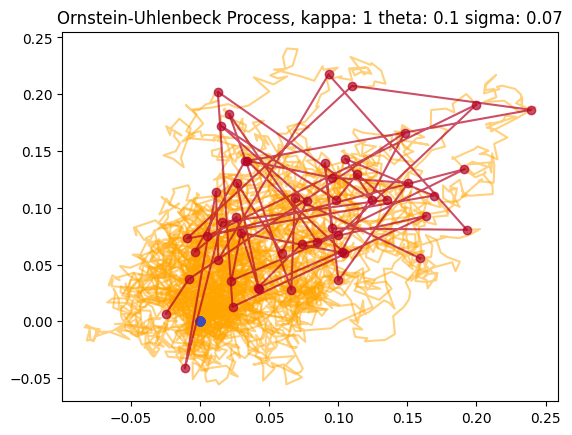

In [3]:
# Euler-Maruyama for OU process


kappa =1
theta = 0.1
batch_size = 50
dim = 2
time_steps = 100
sigma = 0.07
mu = jnp.ones(dim) * 1.0
ou_sde = Ornstein_Uhlenbeck_SDE(theta, mu, sigma)
total_time = 1


x0 = jnp.zeros((batch_size, dim))
rng_key = key_gen()
em_ou = EulerMaruyama.from_sde(ou_sde, x0, total_time/time_steps, total_time, batch_size, rng_key)
training_data, diffusion_history = em_ou.solve()
print(training_data.shape)
plot_trajectory_2d(training_data, "Ornstein-Uhlenbeck Process, kappa: "+str(kappa)+" theta: "+str(theta)+" sigma: "+str(sigma))
def get_timestep_embedding(t, embedding_dim=128):
    """
    Build sinusoidal embeddings for a single time value (adapted from Fairseq to JAX).
    
    Parameters
    ----------
    t : float or jnp.ndarray 
        Single time value
    embedding_dim : int 
        Dimension of time embedding
                        
    Returns
    -------    
    emb : jnp.ndarray
        Time embedding of shape (embedding_dim,)
    """
    
    scaling_factor = 100.0
    half_dim = embedding_dim // 2
    
    # Create embedding
    emb = jnp.log(10000.0) / (half_dim - 1)
    emb = jnp.exp(jnp.arange(half_dim, dtype=jnp.float32) * -emb)
    emb = scaling_factor * emb * t
    
    # Compute sin and cos embeddings
    emb = jnp.concatenate([jnp.sin(emb), jnp.cos(emb)])
    
    # Zero pad if needed
    if embedding_dim % 2 == 1:
        emb = jnp.pad(emb, (0, 1), mode='constant')
        
    return emb


class AdvancedScoreNet(nn.Module):
    hidden_dims: tuple = (128,256,128)

    @nn.compact
    def __call__(self, x, t, dim, with_x0=False, x0=None):
        t = get_timestep_embedding(t, 128)
        t = nn.Dense(features=128)(t)
        t = nn.swish(t)
        if with_x0:
            x = jnp.concatenate([x, x0], axis=-1)
        x = nn.Dense(features=128)(x)
        x = nn.swish(x)
        x = jnp.concatenate([x, t], axis=-1)
        for hidden_dim in self.hidden_dims:
            x = nn.Dense(features=hidden_dim)(x)
            x = nn.swish(x)
        x = nn.Dense(features=dim)(x)
        return x
    
def init_train_state_Brownian(key, model, x, t, dim, with_x0=False, x0=None, lr=1e-2) ->train_state.TrainState:
    params = model.init(key, x, t, dim=dim, with_x0=with_x0, x0=x0)
    optimizer = optax.adam(learning_rate=lr)
    return train_state.TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=optimizer,
    )

In [4]:
model = AdvancedScoreNet()
embedding_dim = 128
state = init_train_state_Brownian(subkey, model, jnp.zeros(dim,), 0, dim)

@partial(jax.jit, static_argnums=(2,3,4,5))
def update_step_OU(key, state, sigma, batch_size, time_steps, dim):
    key, subkey = jrandom.split(key)
    em = EulerMaruyama.from_sde(ou_sde, jnp.zeros((batch_size, dim)), total_time/time_steps, total_time, batch_size, subkey)
    x, diffusion_history = em.solve()
    ts = jnp.linspace(0, 1, time_steps + 1)
    ts = ts[1:]
    dt = 1.0 / time_steps
    x0s = jnp.zeros((batch_size, dim))
    x0s = jnp.expand_dims(x0s, axis=0)
    x0s = jnp.repeat(x0s, time_steps, axis=0)
    x_noised = x[1:, :, :]
    x_originals = x[:-1, :, :]
    
    

    def total_loss(params):
        
        def one_step_dsm(x_original, x_noised, t):
            def mse(x_original, x_noised, t):
                pred = state.apply_fn(params, x_noised, t, dim)
                true = (x_original - x_noised) / (sigma**2 * t)
                return (jnp.linalg.norm(pred - true) ** 2) / 2
            return jnp.mean(jax.vmap(mse, in_axes=(0, 0, None))(x_original, x_noised, t), axis=0)
        return jnp.mean(jax.vmap(one_step_dsm, in_axes=(0, 0, 0))(x0s, x_noised, ts))
    loss, grad = jax.value_and_grad(total_loss)(state.params)
    state = state.apply_gradients(grads=grad)
    return state, loss, key

losses = []
#for i in tqdm.trange(5000, file=sys.stdout):
    
#    subkey = key_gen()
#    state, loss, key = update_step_OU(subkey, state, sigma, batch_size, time_steps, dim)
#    globe_key = key
#    losses.append(loss)
#    if i % 1000 == 0:
#        tqdm.tqdm.write(f"Loss: {loss}")

In [5]:
from src.stats import OU_transition_density_log
from jax import grad

def mse_eval_loss(pred, true):
    return jnp.mean(jnp.linalg.norm(pred - true, axis=0) ** 2)

def OU_score(x,t, x0, t0, theta, sigma):
    sigma = jnp.eye(x0.shape[0]) * sigma
    D = sigma @ sigma.T / theta
    mean = x0 * jnp.exp(-theta*(t-t0))
    variance = D * (1-jnp.exp(-2*theta*(t-t0)))
    # variance = jnp.eye(mean.shape[-1]) * variance
    log_pdf = lambda x : jnp.log(jax.scipy.stats.multivariate_normal.pdf(x, mean, variance))
    return grad(log_pdf)(x)

def plot_score_field_OU(state, dim, time, color='b'):
    x = jnp.linspace(-3, 3, 32)
    y = jnp.linspace(-3, 3, 32)
    x, y = jnp.meshgrid(x, y)
    Z = jnp.stack([x.flatten(), y.flatten()], axis=1)
    Z_dummy = jnp.zeros((Z.shape[0], dim-2))
    Z = jnp.concatenate([Z, Z_dummy], axis=-1)
    result = jax.vmap(lambda x: state.apply_fn(state.params, x, time, dim), in_axes=(0))(Z)
    x0 = jnp.zeros(dim)
    real_score = jax.vmap(lambda x: OU_score(x, time, x0, 0, theta, sigma), in_axes=(0))(Z) #x0 should not be (batch_size, dim) or grad will error
    loss = jax.vmap(mse_eval_loss)(result, real_score)
    fig, ax = plt.subplots(figsize=(10, 10))
    q1 = ax.quiver(Z[:, 0], Z[:, 1],real_score[:, 0], real_score[:, 1], color='tomato', zorder=10, pivot='mid',units='xy')
    # qk1 = ax.quiverkey(q1, 0.9, 0.9, 1, r'$1 \frac{m}{s}$', labelpos='E',
                   # coordinates='figure')
    q2 = ax.quiver(Z[:, 0], Z[:, 1],result[:, 0], result[:, 1], color=color, zorder=5, pivot='mid',units='xy')
    # qk2 = ax.quiverkey(q2, 0.9, 0.9, 1, r'$1 \frac{m}{s}$', labelpos='S',
    #                coordinates='figure')
    ax.scatter(Z[:, 0], Z[:, 1], color='black', zorder=15, s=1)
    ax.set_title("Score field of Brownian Motion at time " + str(time)+ ", loss: " + str(jnp.mean(loss)))
    ax.legend(["True score", "Learned score"])
    plt.show()
    
# for i in range(10):
#    plot_score_field_OU(state, dim, (i+1) * 0.1, color='deepskyblue')
# # plot_score_field_OU(state, dim, 2, color='b')


When sigma is small, the data cannot be spread out in the whole space, so the learned score is not accurate.
When sigma is large, the data is more spread out, so the learned score is more accurate.

## 4.3 Brownian Bridge (learn score on the original process and use the score to generate the reversed process)


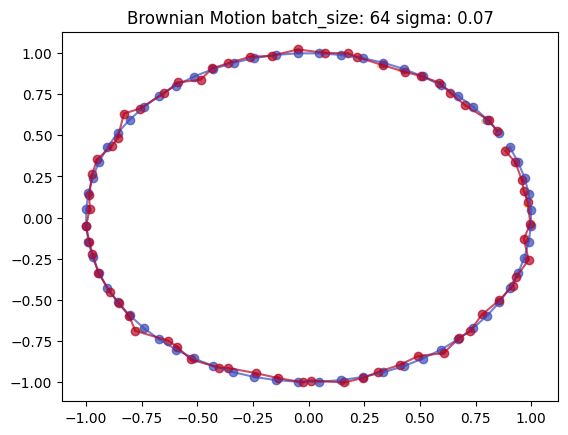

In [6]:
batch_size = 64
# let x0 be a sample from a circle, sample size is batch_size, sample on the circle uniformly
radius = 1
time_steps = 128
total_time = 0.07

def generate_circle_data(batch_size, radius):
    step_size = 2*jnp.pi / (batch_size-1)
    rand_phase = jrandom.uniform(key_gen())
    circle_x0 = jnp.stack([radius * jnp.cos(jnp.linspace(rand_phase, 2*jnp.pi-step_size + rand_phase, batch_size)), radius * jnp.sin(jnp.linspace(rand_phase, 2*jnp.pi-step_size + rand_phase, batch_size))], axis=-1)
    return circle_x0


circle_x0 = generate_circle_data(batch_size, radius)
Brownian_SDE = Brownian_Motion_SDE(dim, sigma)
sde_solver = EulerMaruyama.from_sde(Brownian_SDE, circle_x0, total_time/time_steps, total_time, batch_size, key_gen()) 
training_data_brownian, diffusion_history_brownian = sde_solver.solve()
plot_trajectory_2d(training_data_brownian, "Brownian Motion"+" batch_size: "+str(batch_size)+" sigma: "+str(sigma))

## 5. Kunita Flow

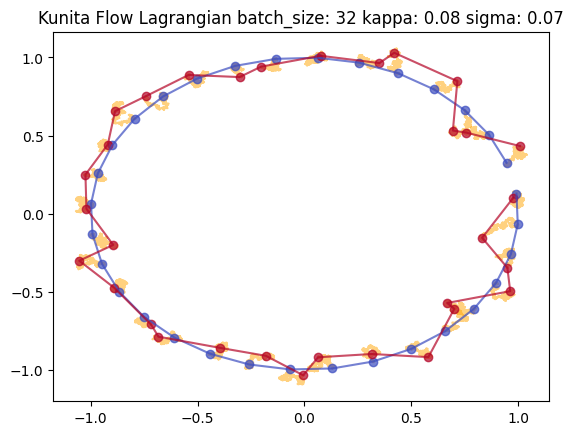

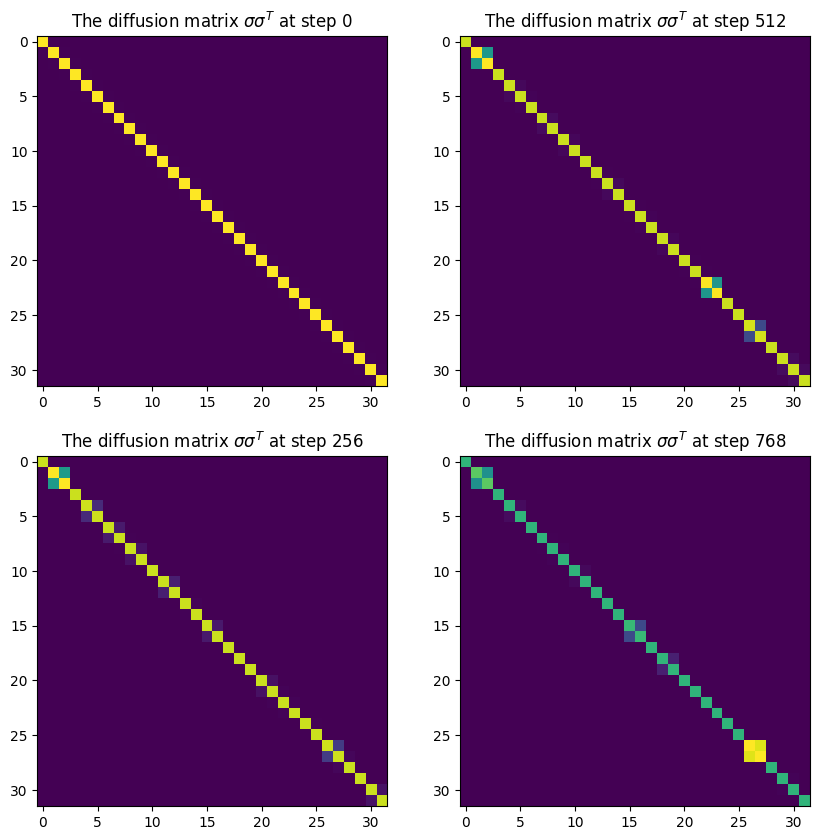

In [7]:
sigma = 0.07
kappa = 0.08
Kunita_flow = Kunita_Lagrange_SDE(sigma, kappa)
batch_size = 32
time_steps = 1024
total_time = 1.0
circle_x0 = generate_circle_data(batch_size, radius)

sde_solver = EulerMaruyama.from_sde(Kunita_flow, circle_x0, total_time/time_steps, total_time, batch_size, key_gen()) 
training_data_lagrangian, diffusion_history_lagrangian = sde_solver.solve()
plot_trajectory_2d(training_data_lagrangian, "Kunita Flow Lagrangian"+" batch_size: "+str(batch_size)+" kappa: "+str(kappa)+" sigma: "+str(sigma))
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,10))
for i in range(2):
    for j in range(2):
        ax[i,j].imshow(jnp.linalg.matmul(diffusion_history_lagrangian[time_steps*(i+j*2)//4], diffusion_history_lagrangian[time_steps*(i+j*2)//4].T))
        ax[i,j].set_title("The diffusion matrix $\sigma\sigma^T$ at step "+str(time_steps*(i+j*2)//4))
        # for k in range(batch_size):
        #     for l in range(batch_size):
        #         # use the scientific notation for the text
        #         ax[i,j].text(l, k, str("{:.2e}".format(diffusion_history[time_steps*(i+j*2)//4][k,l])), color='w', ha='center', va='center', fontsize=6)


plt.show()



(1025, 32, 2)
(1024, 32, 1024)


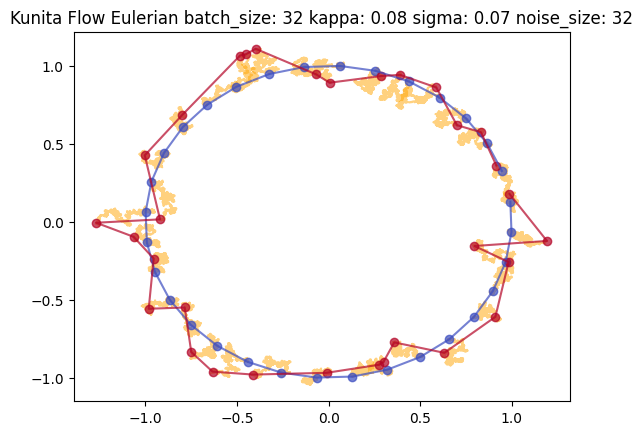

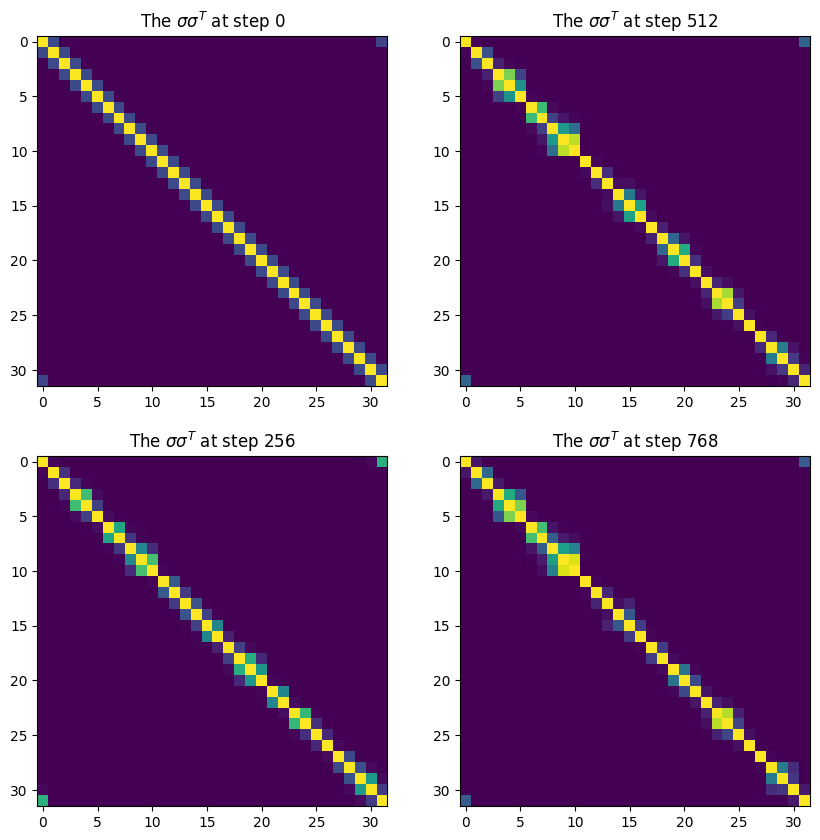

In [8]:

noise_size = 32
Kunita_flow_Eulerian = Kunita_Eulerian_SDE(sigma, kappa, 2, noise_size,(-1.5,1.5))
sde_solver = EulerMaruyama.from_sde(Kunita_flow_Eulerian, circle_x0, total_time/time_steps, total_time, noise_size**2, key_gen()) 
training_data_eulerian, diffusion_history_eulerian = sde_solver.solve()
print(training_data_eulerian.shape)
print(diffusion_history_eulerian.shape)
plot_trajectory_2d(training_data_eulerian, "Kunita Flow Eulerian"+" batch_size: "+str(batch_size)+" kappa: "+str(kappa)+" sigma: "+str(sigma) + " noise_size: "+str(noise_size))
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,10))
for i in range(2):
    for j in range(2):
        ax[i,j].imshow(jnp.linalg.matmul(diffusion_history_eulerian[time_steps*(i+j*2)//4], diffusion_history_eulerian[time_steps*(i+j*2)//4].T))
        ax[i,j].set_title("The $\sigma\sigma^T$ at step "+str(time_steps*(i+j*2)//4))
        # for k in range(batch_size):
        #     for l in range(noise_size ** 2):
        #         # use the scientific notation for the text
        #         ax[i,j].text(l, k, str("{:.2e}".format(diffusion_history[time_steps*(i+j*2)//4][k,l])), color='w', ha='center', va='center', fontsize=6)


plt.show()




### 5.1 Score matching for Kunita Flow


In [21]:
from src.data.ToyData import generate_circle_datas

model = AdvancedScoreNet()

radius = 1
batch_size = 128
embedding_dim = 128
circle_x0 = generate_circle_datas(batch_size, 10, radius)
state = init_train_state_Brownian(subkey, model, jnp.zeros(dim,), 0, dim, with_x0=True, x0=circle_x0[2], lr=1e-3)
@partial(jax.jit, static_argnums=(2,3,4,5,6,7,8,9))
def update_step_Kunita(key, state, sigma, kappa, batch_size, time_steps, dim, SDE_type="Eulerian", noise_size=16, object_fn="Heng"):
    key, subkey = jrandom.split(key)
    SDE = None
    training_data = None
    if SDE_type == "Eulerian":
        Kunita_flow_Eulerian = Kunita_Eulerian_SDE(sigma, kappa, 2, noise_size,(-2,2))
        sde_solver = EulerMaruyama.from_sde(Kunita_flow_Eulerian, circle_x0, total_time/time_steps, total_time, noise_size**2, key_gen()) 
        training_data_eulerian, diffusion_history_eulerian = sde_solver.solve()
        training_data = training_data_eulerian
        SDE = Kunita_flow_Eulerian
    elif SDE_type == "Brownian":
        Brownian_SDE = Brownian_Motion_SDE(dim, sigma)
        sde_solver = EulerMaruyama.from_sde(Brownian_SDE, circle_x0, total_time/time_steps, total_time, batch_size, key_gen()) 
        training_data_brownian, diffusion_history_brownian = sde_solver.solve()
        training_data = training_data_brownian
        SDE = Brownian_SDE
    elif SDE_type == "Lagrangian":
        Kunita_flow_Lagrangian = Kunita_Lagrange_SDE(sigma, kappa)
        sde_solver = EulerMaruyama.from_sde(Kunita_flow_Lagrangian, circle_x0, total_time/time_steps, total_time, batch_size, key_gen()) 
        training_data_lagrangian, diffusion_history_lagrangian = sde_solver.solve()
        training_data = training_data_lagrangian
        SDE = Kunita_flow_Lagrangian
    ts = jnp.linspace(0, 1, time_steps + 1) # linspace will include the end point, so the length is time_nums, the step_num is time_nums - 1
    dt = total_time/ time_steps # the time step is the total time divided by the number of steps(intervals)
    x0s = circle_x0
    x0s = jnp.expand_dims(x0s, axis=0)
    x0s = jnp.repeat(x0s, time_steps, axis=0)
    xs_noiseds = training_data[1:, :, :]
    xs_originals = training_data[:-1, :, :]
    

    def total_loss(params):
        def one_step_dsm(xs_original, xs_noised, t, x0s):
            
            def loss_for_one_x(x_original, x_noised, t, x0):
                # 1. Compute Sigma at current time t
                Sigma_current = SDE.Sigma()(x_noised, t)
                # Sigma_current = Sigma_current + 1e-6 * jnp.eye(Sigma_current.shape[0])
                Sigma_prev = SDE.Sigma()(x_original, t-dt)

                if object_fn == 'Heng':
                    Sigma_prev = Sigma_prev + 1e-4 * jnp.eye(Sigma_prev.shape[0])
                    #use lstsq to obtain the inverse of Sigma_current
                    # Sigma_current_inv = jnp.linalg.lstsq(Sigma_current, jnp.eye(Sigma_current.shape[0]), rcond=None)[0]
                
                    Sigma_prev_inv = jnp.linalg.solve(Sigma_prev, jnp.eye(Sigma_prev.shape[0]))
                    # Sigma_prev_inv = jnp.linalg.lstsq(Sigma_prev, jnp.eye(Sigma_prev.shape[0]))[0]
                    # 2. Score approximation from neural network
                    pred_score = state.apply_fn(params, x_noised, t, dim, with_x0=True, x0=x0)
                    # 3. True score approximation using Euler-Maruyama
                    g_approx = -jnp.matmul(Sigma_prev_inv, (x_noised - x_original - dt * SDE.drift_fn()(x_original, t-dt)))/dt
                    # 4. Compute squared Sigma-weighted norm of difference
                    diff = pred_score - g_approx
                    loss = jnp.matmul(
                        diff.T, 
                        jnp.matmul(Sigma_current, diff)
                    )
                else:
                    # 2. Score approximation from neural network
                    pred_score = state.apply_fn(params, x_noised, t, dim, with_x0=True, x0=x0)
                    # 3. True score approximation using Euler-Maruyama
                    approx_stable = (x_noised - x_original - dt * SDE.drift_fn()(x_original, t-dt))
                    g_approx = approx_stable
                    loss = pred_score.T @ (Sigma_current * dt) @ pred_score + 2 * pred_score.T @ approx_stable
                    loss = loss * dt
               
                
                
                return loss, pred_score, g_approx
            
            batch_loss, pred_scores, true_scores = jax.vmap(loss_for_one_x, in_axes=(0, 0, None, 0))(
                xs_original, xs_noised, t, x0s
            )

            return jnp.mean(batch_loss), (pred_scores, true_scores)
        
        total_loss_and_stats = jax.vmap(one_step_dsm, in_axes=(0, 0, 0, 0))(
                xs_originals, xs_noiseds, ts[1:], x0s
            )
        total_loss = total_loss_and_stats[0]
        stats = total_loss_and_stats[1]
        total_loss = jnp.sum(total_loss) * dt * 0.5



        
        return total_loss, stats
    (loss, stats), grad = jax.value_and_grad(total_loss, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grad)
    return state, loss, key, stats

losses = []

time_steps = 512
sigma = 0.007
kappa = 0.08
noise_size = 32


for i in tqdm.trange(30000, file=sys.stdout):
    subkey = key_gen()
    state, loss, key, stats = update_step_Kunita(subkey, state, sigma, kappa, batch_size , time_steps, dim, SDE_type="Eulerian", noise_size=noise_size, object_fn="Novel")
    globe_key = key
    losses.append(loss)
    if i % 1000 == 0:
        tqdm.tqdm.write(f"Loss: {loss}")
Brownian_SDE = Brownian_Motion_SDE(dim, sigma)
Eulerian_SDE = Kunita_Eulerian_SDE(sigma, kappa, 2, noise_size,(-2,2))
Lagrangian_SDE = Kunita_Lagrange_SDE(sigma, kappa)
 
print("pred_scores range: ", jnp.max(stats[0]), jnp.min(stats[0]))
print("true_scores range: ", jnp.max(stats[1]), jnp.min(stats[1]))


# reversed_sde_kunita = Time_Reversed_SDE(Kunita_flow_Lagrangian, score_fn, total_time)
# reversed_sde_kunita = Time_Reversed_SDE(Brownian_SDE, score_fn, total_time)

        

Loss: 1.1889308981771762e-11             
Loss: -3.064548218389973e-05                        
Loss: -0.00023831498401705176                       
Loss: -0.0003323980781715363                        
Loss: -0.00039840361569076777                       
Loss: -0.0004412391863297671                        
Loss: -0.0004716667754109949                        
Loss: -0.0005073662614449859                        
Loss: -0.0005317370523698628                        
Loss: -0.0005465916474349797                        
Loss: -0.0005543063743971288                        
Loss: -0.0005809326539747417                         
Loss: -0.0006083418265916407                         
Loss: -0.0006017005071043968                         
Loss: -0.0006252994062379003                         
Loss: -0.0006391593487933278                         
Loss: -0.0006065134657546878                         
Loss: -0.0006743978592567146                         
Loss: -0.0006142141064628959                      

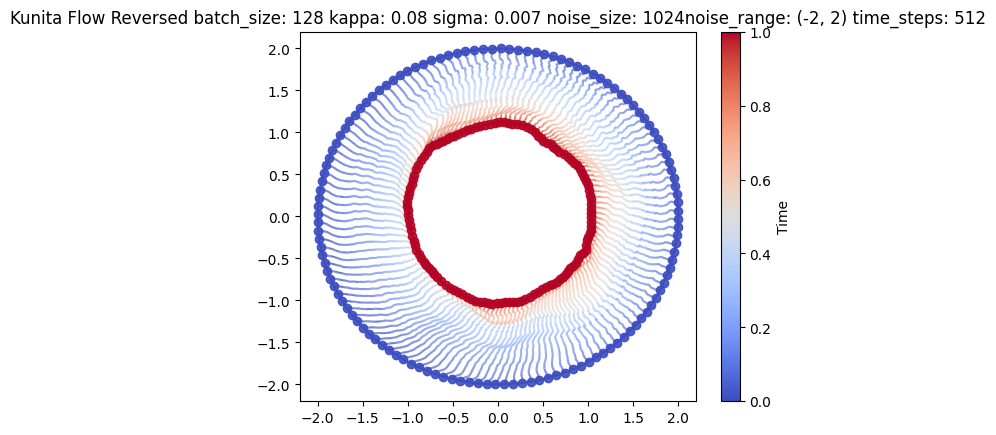

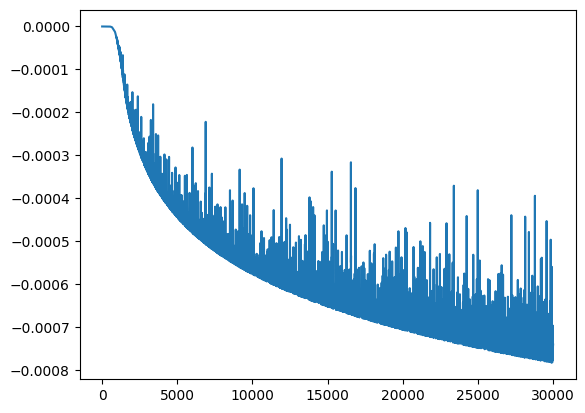

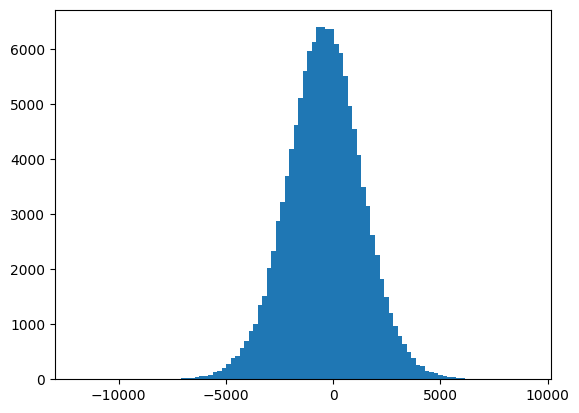

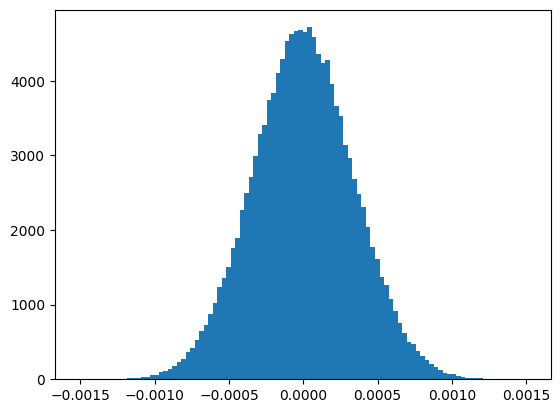

In [22]:
noise_size = 32
score_fn = jax.vmap(lambda x, t, x0: state.apply_fn(state.params, x, t, dim, with_x0=True, x0=x0), in_axes=(0, None, 0))
dt = total_time / time_steps
# testing_kunita = Brownian_SDE
testing_kunita = Eulerian_SDE
# testing_kunita = Lagrangian_SDE
if testing_kunita == Brownian_SDE:
    noise_size = batch_size
elif testing_kunita == Eulerian_SDE:
    noise_size = noise_size**2
elif testing_kunita == Lagrangian_SDE:
    noise_size = batch_size
reversed_sde_kunita = Time_Reversed_SDE(testing_kunita, score_fn, total_time, dt)
circle_x0 = generate_circle_data(batch_size, radius)
sde_solver_test = EulerMaruyama.from_sde(testing_kunita, circle_x0, total_time/time_steps, total_time, noise_size, key_gen(), debug_mode=False)
testing_data, diffusion_history_test = sde_solver_test.solve()
testing_data = generate_circle_data(batch_size, radius*2)
# plot_trajectory_2d(testing_data, "Kunita Flow Testing"+" batch_size: "+str(batch_size)+" kappa: "+str(kappa)+" sigma: "+str(sigma)+" noise_size: "+str(noise_size)+"noise_range: "+str((-2,2))+" time_steps: "+str(time_steps), simplified=False)
sde_solver = EulerMaruyama.from_sde(reversed_sde_kunita, testing_data, total_time/time_steps, total_time, noise_size, key_gen(), x0_list=circle_x0, debug_mode=False)
# Brownian_SDE = Brownian_Motion_SDE(dim, sigma)
# sde_solver = EulerMaruyama.from_sde(reversed_sde_kunita, training_data_brownian[-1], total_time/time_steps, total_time, batch_size, key_gen()) 

training_data_reversed, diffusion_history_reversed = sde_solver.solve()
plot_trajectory_2d(training_data_reversed, "Kunita Flow Reversed"+" batch_size: "+str(batch_size)+" kappa: "+str(kappa)+" sigma: "+str(sigma)+" noise_size: "+str(noise_size)+"noise_range: "+str((-2,2))+" time_steps: "+str(time_steps), simplified=False)

# plot the loss learning curve
plt.plot(losses)
plt.show()

plt.hist(stats[0].flatten(), bins=100)
plt.show()

plt.hist(stats[1].flatten(), bins=100)
plt.show()


# 6 Bridge SDE Simulation
## 6.1 Brownian Bridge

In [15]:

# kernel width start thin to thick
# work on the brownian bridge without learning the score 
# start from the brownian motion, then to the Kunita flow, then to the bridge SDE
# always make the method can be worked on the Brownian motion first

[[[ 1.9914008   0.18526398]
  [ 1.9799125   0.2827482 ]
  [ 1.963655    0.37955132]
  ...
  [ 1.9969893  -0.10970008]
  [ 1.9999664  -0.01158673]
  [ 1.9981261   0.08655454]]

 [[ 1.9957625   0.1804369 ]
  [ 1.9831209   0.28009495]
  [ 1.9632397   0.3774754 ]
  ...
  [ 1.9899824  -0.10036922]
  [ 2.0022671  -0.01020491]
  [ 2.0015225   0.08007897]]

 [[ 1.9964979   0.18571639]
  [ 1.9854391   0.27863488]
  [ 1.9572589   0.37530985]
  ...
  [ 1.9813195  -0.09857616]
  [ 2.0051877  -0.01153446]
  [ 2.0020661   0.07886347]]

 ...

 [[ 0.99731594  0.03460576]
  [ 0.9886779   0.08701572]
  [ 0.9853314   0.13682637]
  ...
  [ 0.9918076  -0.10639191]
  [ 1.0049313  -0.06636313]
  [ 1.0099249  -0.01301946]]

 [[ 0.9922002   0.03693586]
  [ 0.99230236  0.09368487]
  [ 0.9922939   0.13393153]
  ...
  [ 0.9919951  -0.11310849]
  [ 0.99608976 -0.05233026]
  [ 0.9976883  -0.00497391]]

 [[ 1.0074064   0.04528375]
  [ 0.99736917  0.09030594]
  [ 0.9849446   0.14604649]
  ...
  [ 1.0020351  -0.095376

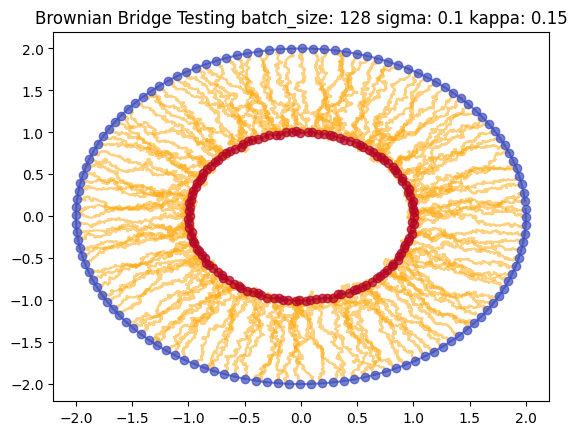

In [16]:
from jax.scipy.stats import norm
sigma = 0.1
kappa = 0.15
total_time = 1.0
time_steps = 1024
dt = total_time / time_steps
noise_size = 32
Brownian_bridge_SDE = Brownian_Motion_SDE(sigma, kappa)
# Brownian_bridge_SDE = Kunita_Eulerian_SDE(sigma, kappa, 2, noise_size,(-0.5,0.5))
noise_size = batch_size
score_fn = jax.vmap(lambda x, t, x0: (x0-x)/(sigma**2*t), in_axes=(0, None, 0))
reversed_sde_brownian_bridge = Time_Reversed_SDE(Brownian_bridge_SDE, score_fn, total_time, dt)
circle_x0 = generate_circle_data(batch_size, radius)
forward_sde_solver = EulerMaruyama.from_sde(Brownian_bridge_SDE, circle_x0, total_time/time_steps, total_time, noise_size, key_gen(), debug_mode=False) 
forward_data, diffusion_history_forward = forward_sde_solver.solve()
reversed_start_point = generate_circle_data(batch_size, radius*2)
sde_solver_test = EulerMaruyama.from_sde(reversed_sde_brownian_bridge, reversed_start_point, total_time/time_steps, total_time, noise_size, key_gen(), x0_list=circle_x0, debug_mode=False) 
testing_data, diffusion_history_test = sde_solver_test.solve()
print(testing_data)
plot_trajectory_2d(testing_data, "Brownian Bridge Testing"+" batch_size: "+str(batch_size)+" sigma: "+str(sigma)+" kappa: "+str(kappa))